In [59]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as stats
from great_tables import GT, style, loc, md
import seaborn as sns

In [43]:
files = os.listdir('baseline_merged')
files = [file for file in files if file.endswith('.csv')]

baseline_merged = pd.concat([pd.read_csv(f'baseline_merged/{file}') for file in files])
baseline_merged.dropna(subset='recc_rate', inplace=True)

baseline_merged=baseline_merged[~baseline_merged['User'].isin(['Nathan Worrell','Liam Jagrowski','Henry Cross','Dylan Orr','Jacob Swain','John Hazelton','Brian Dietrich'])]

baseline_merged['InputtedRent'] = baseline_merged['InputtedRent'].str.replace(',','').astype(float)
baseline_merged['RecommendationDate'] = pd.to_datetime(baseline_merged['RecommendationDate'])

AssetDetailActive = pd.read_csv('data/vw_AssetDetailActive.csv')

baseline_merged = baseline_merged.merge(AssetDetailActive, on='AssetName')

baseline_merged['Diff'] = baseline_merged['InputtedRent'] - baseline_merged['recc_rate']

In [44]:
baseline_merged['accepted'] = abs(baseline_merged['InputtedRent'] - baseline_merged['recc_rate']) < 1
baseline_merged['accepted_range'] = (baseline_merged['InputtedRent'] >= baseline_merged['recc_rate_lower']) & (baseline_merged['InputtedRent'] <= baseline_merged['recc_rate_upper'])

rejections = baseline_merged[~baseline_merged['accepted']]
rejections['increase'] = rejections['Diff'] > 0
rejections['decrease'] = rejections['Diff'] < 0

C:\Users\Tyson.King\AppData\Local\Temp\ipykernel_37636\326457472.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rejections['increase'] = rejections['Diff'] > 0
C:\Users\Tyson.King\AppData\Local\Temp\ipykernel_37636\326457472.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rejections['decrease'] = rejections['Diff'] < 0


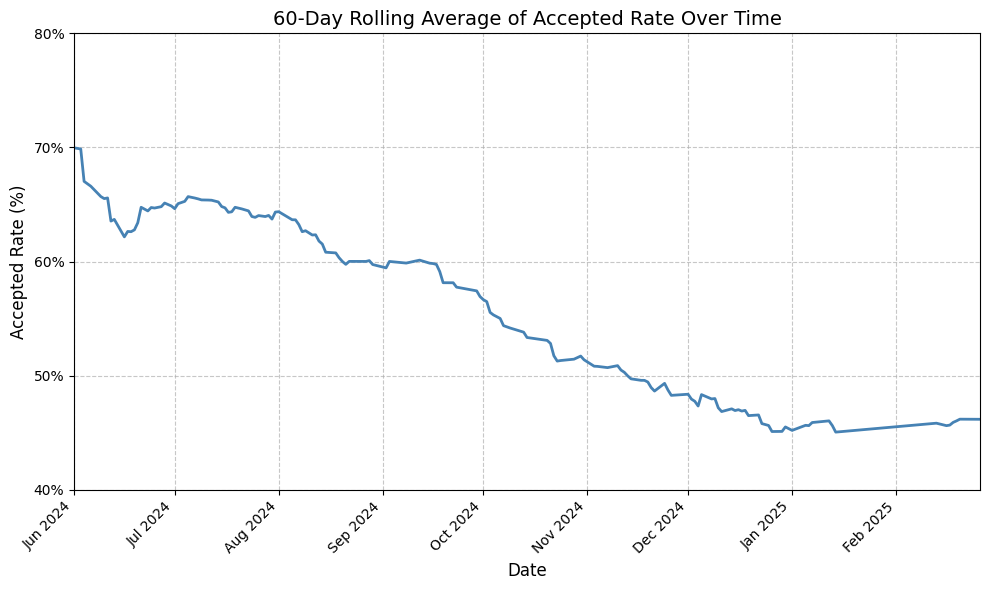

In [45]:
# Calculate daily average of accepted rate
daily_avg = baseline_merged.groupby('RecommendationDate')['accepted_range'].mean()

daily_avg.to_csv('test.csv')

# Calculate rolling average of accepted rate over time
rolling_avg = daily_avg.rolling(window=60, min_periods=1).mean()

plt.figure(figsize=(10, 6))
plt.plot(rolling_avg, color='steelblue', linewidth=2)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Accepted Rate (%)', fontsize=12)
plt.title('60-Day Rolling Average of Accepted Rate Over Time', fontsize=14)
plt.xlim(pd.to_datetime('2024-06-01'), max(daily_avg.index))
plt.ylim(0.4, 0.8)
plt.yticks([0.4, 0.5, 0.6, 0.7, 0.8], ['40%', '50%', '60%', '70%', '80%'])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.style.use('seaborn-v0_8-muted')
plt.tight_layout()
plt.show()

In [46]:
accepted_pct = (baseline_merged['accepted_range']).mean()
accepted_pct = round(accepted_pct * 100, 1)

rejected_inc = (rejections['increase']).mean()
rejected_dec = 1 - rejected_inc


rejected_inc = round(rejected_inc * 100, 1)
rejected_dec = round(rejected_dec * 100, 1)

# Print out values for debugging
print(f"Accepted percentage: {accepted_pct}")
print(f"Rejected Increase percentage: {rejected_inc}")
print(f"Rejected Decrease percentage: {rejected_dec}")

Accepted percentage: 52.5
Rejected Increase percentage: 63.3
Rejected Decrease percentage: 36.7


In [47]:
by_unitgroup = baseline_merged.groupby('FloorPlanGroupName').agg(
    count = ('accepted', 'count'),
    acceptance_rate = ('accepted_range', 'mean'),
    median_adjustment = ('Diff', 'median')
).sort_values('acceptance_rate', ascending=False).reset_index()

by_unitgroup = by_unitgroup[by_unitgroup['count'] > 50]

# Create a GT object
table = GT(by_unitgroup[['FloorPlanGroupName', 'acceptance_rate', 'median_adjustment']])

table = (
    table
    .cols_label(FloorPlanGroupName = md("**Unit Group**"),
                acceptance_rate = md("**Acceptance Rate**"),
                median_adjustment = md("**Median Adjustment**"))
    .tab_header(title = "Price Change Metrics by Unit Group")
    .fmt_currency(columns = 2)
    .fmt_percent(columns = 1)
    .tab_style(
        style=style.text(style="italic"),
        locations = loc.body(columns=0)
    )
)

table

GT(_tbl_data=   FloorPlanGroupName  acceptance_rate  median_adjustment
0                 2x2         0.600679           4.511061
1               2x1.5         0.577320          -1.280355
2                 3x2         0.558180          24.295654
3                 1x1         0.527410           8.047323
7               1x1.5         0.486842          42.224942
8               3x2.5         0.444444          12.943115
9               2x2.5         0.440594          39.602690
10                2x1         0.438776          35.514730
14                0x1         0.367403          35.458035
15                3x3         0.333333          -9.713135, _body=<great_tables._gt_data.Body object at 0x00000223AFFFC450>, _boxhead=Boxhead([ColInfo(var='FloorPlanGroupName', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Unit Group**'), column_align='left', column_width=None), ColInfo(var='acceptance_rate', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Acceptance Rate**'), column_align='right', column_width=None), ColInfo(var='median_adjustment', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Median Adjustment**'), column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x00000223AF9FA2D0>, _spanners=Spanners([]), _heading=Heading(title='Price Change Metrics by Unit Group', subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='FloorPlanGroupName', rownum=0, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='FloorPlanGroupName', rownum=1, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='FloorPlanGroupName', rownum=2, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='FloorPlanGroupName', rownum=3, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='FloorPlanGroupName', rownum=4, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='FloorPlanGroupName', rownum=5, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='FloorPlanGroupName', rownum=6, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='FloorPlanGroupName', rownum=7, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='FloorPlanGroupName', rownum=8, colnum=None, styles=[Cell

In [48]:
by_rm = baseline_merged.groupby(['MarketName']).agg(
    count = ('accepted', 'count'),
    acceptance_rate = ('accepted_range', 'mean'),
    median_adjustment = ('Diff', 'median')
).sort_values('acceptance_rate', ascending=False).reset_index()


display(by_rm)

,MarketName,count,acceptance_rate,median_adjustment
0,"Boise City, ID",9,0.777778,0.246413
1,"West Palm Beach-Boca Raton-Delray Beach, FL",80,0.687500,-0.349835
2,"Birmingham-Hoover, AL",6,0.666667,0.294226
3,"Nashville-Davidson--Murfreesboro--Franklin, TN",179,0.659218,0.226737
4,"Orlando-Kissimmee-Sanford, FL",433,0.621247,-0.054622
5,"Charlotte-Concord-Gastonia, NC-SC",943,0.580064,4.013690
6,"San Antonio-New Braunfels, TX",36,0.555556,23.235111
7,"Raleigh/Durham, NC",770,0.553247,18.450335
8,"Tampa-St. Petersburg-Clearwater, FL",101,0.544554,34.477714
9,"Miami-Miami Beach-Kendall, FL",63,0.539683,59.399577


In [49]:
example_comments = baseline_merged[baseline_merged['ChangeReason'] == 'Other Action taken (see comment)'].dropna(subset='Comment').sample(15)['Comment']

# Save comments to a text file with one observation per line and no index
with open('figures/example_comments.txt', 'w') as f:
    for comment in example_comments:
        f.write(comment + '\n')

In [ ]:
by_property = baseline_merged.groupby(['AssetName', 'User']).agg(
    count = ('accepted', 'count'),
    acceptance_rate = ('accepted_range', 'mean'),
    median_adjustment = ('Diff', 'median')
).sort_values('acceptance_rate', ascending=False).reset_index()

by_property = by_property[by_property['count'] > 20]

# Calculate the overall mean acceptance rate
overall_mean_acceptance_rate = baseline_merged['accepted_range'].mean()

# Function to perform the hypothesis test
def perform_hypothesis_test(asset_name, overall_mean):
    # Get the acceptance rates for the current asset
    asset_data = baseline_merged[baseline_merged['AssetName'] == asset_name]['accepted_range']
    
    # Check if there are enough data points to perform the test
    if len(asset_data) > 1:  # We need at least two data points for a valid t-test
        t_stat, p_value = stats.ttest_1samp(asset_data, overall_mean)
        return p_value
    else:
        return float('nan')  # Return NaN if not enough data to perform t-test


# Apply the hypothesis test for each market and store the results in a new column 'p_value'
by_property['p_value'] = by_property['AssetName'].apply(lambda x: perform_hypothesis_test(x, overall_mean_acceptance_rate))

# Adding a new column 'is_significant' to indicate if p-value is less than 0.05 (95% confidence)
by_property['is_significant'] = by_property['p_value'] < 0.05

by_property = by_property[['AssetName', 'User', 'acceptance_rate', 'median_adjustment', 'count', 'p_value', 'is_significant']]

# Filter markets that are significantly different from the overall mean (p-value < 0.05)
significant_properties = by_property[by_property['is_significant']]

below_average_properties = significant_properties[significant_properties['acceptance_rate'] < overall_mean_acceptance_rate]

# Drop 'p_value' and 'is_significant' columns
below_average_properties = below_average_properties.drop(columns=['count', 'p_value', 'is_significant']).tail(10)

# Create a GT object
table = GT(below_average_properties)

table = (
    table
    .cols_label(AssetName = md("**Property**"),
                User = md("**RM**"),
                acceptance_rate = md("**Acceptance Rate**"),
                median_adjustment = md("**Median Adjustment**"))
    .tab_header(title = "Price Change Metrics by Property",
                subtitle = "(Properties with Significantly Low Acceptance Rate)")
    .fmt_currency(columns = 3)
    .fmt_percent(columns = 2)
    .tab_style(
        style=style.text(style="italic"),
        locations = loc.body(columns=0)
    )
)

table

GT(_tbl_data=                      AssetName           User  acceptance_rate  \
239      Cortland Congress Park  Joshua Bivens         0.323529   
240     Cortland Cary - Phase 1  Melissa Jones         0.302632   
241         Cortland at Coalton  Joshua Bivens         0.300000   
246           Cortland Cap Hill  Joshua Bivens         0.282051   
249  Cortland Rosslyn - Phase 2  Melissa Jones         0.272727   
251         Cortland West Plano     Ruchi Naik         0.269231   
252    Cortland Covington Ridge  Joshua Bivens         0.266667   
265     Cortland at Twin Creeks     Ruchi Naik         0.222222   
268             Cortland at P83  Joshua Bivens         0.200000   
282          Cortland Northlake  Melissa Jones         0.126761   

     median_adjustment  count  
239          84.331189     34  
240          58.989592     76  
241          94.634572     50  
246          88.080363     39  
249          82.245959     33  
251          34.712725     26  
252          72.305000     30  
265          56.486410     45  
268         -25.196411     25  
282          83.292485     71  , _body=<great_tables._gt_data.Body object at 0x00000223B89BBCD0>, _boxhead=Boxhead([ColInfo(var='AssetName', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Property**'), column_align='left', column_width=None), ColInfo(var='User', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**RM**'), column_align='left', column_width=None), ColInfo(var='acceptance_rate', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Acceptance Rate**'), column_align='right', column_width=None), ColInfo(var='median_adjustment', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Median Adjustment**'), column_align='right', column_width=None), ColInfo(var='count', type=<ColInfoTypeEnum.default: 1>, column_label='count', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x00000223B8977310>, _spanners=Spanners([]), _heading=Heading(title='Price Change Metrics by Property', subtitle='(Properties with Significantly Low Acceptance Rate)', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='AssetName', rownum=0, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='AssetName', rownum=1, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='AssetName', rownum=2, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='AssetName', rownum=3, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='AssetName', rownum=4, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='AssetName', rownum=5, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grp

In [55]:
baseline_merged['AcquisitionDate_numeric'] = pd.to_datetime(baseline_merged['AcquisitionDate']).astype(int) / 10**9

# Perform the aggregation
by_market = baseline_merged.groupby(['MarketName']).agg(
    count=('accepted', 'count'),
    acceptance_rate=('accepted_range', 'mean'),
    num_assets=('AssetName', 'nunique'),
    acquisition_date_numeric=('AcquisitionDate_numeric', 'min'),
    median_adjustment=('Diff', 'median')
).sort_values('acceptance_rate', ascending=False).reset_index()

# Convert the numeric values back to dates
by_market['acquisition_date'] = pd.to_datetime(by_market['acquisition_date_numeric'], unit='s')
by_market.drop(columns=['acquisition_date_numeric'], inplace=True)

# Function to perform the hypothesis test
def perform_hypothesis_test(market_name, overall_mean):
    # Get the acceptance rates for the current market
    market_data = baseline_merged[baseline_merged['MarketName'] == market_name]['accepted_range']
    
    # Check if there are enough data points to perform the test
    if len(market_data) > 1:  # We need at least two data points for a valid t-test
        t_stat, p_value = stats.ttest_1samp(market_data, overall_mean)
        return p_value
    else:
        return float('nan')  # Return NaN if not enough data to perform t-test

# Apply the hypothesis test for each market and store the results in a new column 'p_value'
by_market['p_value'] = by_market['MarketName'].apply(lambda x: perform_hypothesis_test(x, overall_mean_acceptance_rate))

# Adding a new column 'is_significant' to indicate if p-value is less than 0.05 (95% confidence)
by_market['is_significant'] = by_market['p_value'] < 0.05

by_market = by_market[['MarketName', 'num_assets', 'acquisition_date', 'acceptance_rate', 'median_adjustment', 'count', 'p_value', 'is_significant']]

# Filter markets that are significantly different from the overall mean (p-value < 0.05)
significant_markets = by_market[by_market['is_significant']]

below_average_markets = significant_markets[significant_markets['acceptance_rate'] < overall_mean_acceptance_rate]

# Drop 'p_value' and 'is_significant' columns
below_average_markets = below_average_markets.drop(columns=['count', 'p_value', 'is_significant'])

# Create a GT object
table = GT(below_average_markets)

table = (
    table
    .cols_label(MarketName = md("**Market**"),
                num_assets = md("**# Assets**"),
                acquisition_date = md("**Earliest Acquisition**"),
                acceptance_rate = md("**Acceptance Rate**"),
                median_adjustment = md("**Median Adjustment**"))
    .tab_header(title = "Price Change Metrics by Market",
                subtitle = "(Markets with Significantly Low Acceptance Rate)")
    .fmt_currency(columns = 4)
    .fmt_percent(columns = 3)
    .tab_style(
        style=style.text(style="italic"),
        locations = loc.body(columns=0)
    )
)

table

# Display the table
# table.save('figures/low_acc_bymarket.png')


GT(_tbl_data=                     MarketName  num_assets acquisition_date  acceptance_rate  \
20   Denver-Aurora-Lakewood, CO          15       2017-12-19         0.413534   
21     Fort Worth-Arlington, TX          11       2014-02-07         0.410405   
24                   Tucson, AZ           5       2021-08-16         0.362319   
25  Phoenix-Mesa-Scottsdale, AZ          14       2019-03-11         0.310638   

    median_adjustment  
20          49.369019  
21          42.446230  
24          38.152918  
25          37.655504  , _body=<great_tables._gt_data.Body object at 0x00000223AFC6F910>, _boxhead=Boxhead([ColInfo(var='MarketName', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Market**'), column_align='left', column_width=None), ColInfo(var='num_assets', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**# Assets**'), column_align='right', column_width=None), ColInfo(var='acquisition_date', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Earliest Acquisition**'), column_align='right', column_width=None), ColInfo(var='acceptance_rate', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Acceptance Rate**'), column_align='right', column_width=None), ColInfo(var='median_adjustment', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Median Adjustment**'), column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x00000223AFF9B150>, _spanners=Spanners([]), _heading=Heading(title='Price Change Metrics by Market', subtitle='(Markets with Significantly Low Acceptance Rate)', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='MarketName', rownum=0, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='MarketName', rownum=1, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='MarketName', rownum=2, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='MarketName', rownum=3, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)])], _locale=<great_tables._gt_data.Locale object at 0x00000223AFF70A90>, _formats=[<great_tables._gt_data.FormatInfo object at 0x00000223AF9F7490>, <great_tables._gt_data.FormatInfo object at 0x00000223AFB7F990>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-ser

In [52]:
# Create a GT object
table = GT(by_market.drop(columns=['count', 'p_value', 'is_significant']))

table = (
    table
    .cols_label(MarketName = md("**Market**"),
                num_assets = md("**# Assets**"),
                acquisition_date = md("**Earliest Acquisition**"),
                acceptance_rate = md("**Acceptance Rate**"),
                median_adjustment = md("**Median Adjustment**"))
    .tab_header(title = "Price Change Metrics by Market")
    .fmt_currency(columns = 4)
    .fmt_percent(columns = 3)
    .tab_style(
        style=style.text(style="italic"),
        locations = loc.body(columns=0)
    )
)

# Display the table
table.save('figures/acc_bymarket.png')

GT(_tbl_data=                                           MarketName  num_assets  \
0                                      Boise City, ID           3   
1         West Palm Beach-Boca Raton-Delray Beach, FL           6   
2                               Birmingham-Hoover, AL           1   
3      Nashville-Davidson--Murfreesboro--Franklin, TN           3   
4                       Orlando-Kissimmee-Sanford, FL          14   
5                   Charlotte-Concord-Gastonia, NC-SC          11   
6                       San Antonio-New Braunfels, TX           5   
7                                  Raleigh/Durham, NC          11   
8                 Tampa-St. Petersburg-Clearwater, FL          14   
9                       Miami-Miami Beach-Kendall, FL           6   
10                                   Fort Collins, CO           1   
11                  Atlanta-Sandy Springs-Roswell, GA          36   
12               Houston-The Woodlands-Sugar Land, TX          13   
13                                       Columbus, OH          14   
14                            Dallas-Plano-Irving, TX          31   
15                              Austin-Round Rock, TX           6   
16  Fort Lauderdale-Pompano Beach-Deerfield Beach, FL           4   
17                 Chicago-Naperville-Elgin, IL-IN-WI           1   
18       Washington-Arlington-Alexandria, DC-VA-MD-WV           5   
19                               Colorado Springs, CO           5   
20                         Denver-Aurora-Lakewood, CO          15   
21                           Fort Worth-Arlington, TX          11   
22             Deltona-Daytona Beach-Ormond Beach, FL           1   
23                          Lakeland-Winter Haven, FL           1   
24                                         Tucson, AZ           5   
25                        Phoenix-Mesa-Scottsdale, AZ          14   

   acquisition_date  acceptance_rate  median_adjustment  
0        2021-12-14         0.777778           0.246413  
1        2020-07-23         0.687500          -0.349835  
2        2017-06-22         0.666667           0.294226  
3        2021-09-16         0.659218           0.226737  
4        2018-07-17         0.621247          -0.054622  
5        2017-09-29         0.580064           4.013690  
6        2019-09-27         0.555556          23.235111  
7        2018-01-19         0.553247          18.450335  
8        2019-04-01         0.544554          34.477714  
9        2021-08-24         0.539683          59.399577  
10       2021-05-25         0.525000          40.810298  
11       2016-12-31         0.524851          28.735490  
12       2017-06-27         0.520710           5.682097  
13       2014-09-30         0.519038          -0.336809  
14       2017-07-31         0.516234          22.944723  
15       2017-07-28         0.509091          17.940922  
16       2021-01-06         0.486486          60.613281  
17       2022-06-28         0.464286          31.208291  
18       2022-05-17         0.461039          48.720180  
19       2016-11-30         0.435897          46.700806  
20       2017-12-19         0.413534          49.369019  
21       2014-02-07         0.410405          42.446230  
22       2021-08-24         0.408163          19.405843  
23       2021-07-09         0.363636         -62.957663  
24       2021-08-16         0.362319          38.152918  
25       2019-03-11         0.310638          37.655504  , _body=<great_tables._gt_data.Body object at 0x00000223AFA49C10>, _boxhead=Boxhead([ColInfo(var='MarketName', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Market**'), column_align='left', column_width=None), ColInfo(var='num_assets', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**# Assets**'), column_align='right', column_width=None), ColInfo(var='acquisition_date', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Earliest Acquisition**'), column_align='right', column_width=None), ColInfo(var='acceptance_rate', type

In [53]:
above_average_markets = significant_markets[significant_markets['acceptance_rate'] > overall_mean_acceptance_rate]

# Drop 'p_value' and 'is_significant' columns
above_average_markets = above_average_markets.drop(columns=['count', 'p_value', 'is_significant'])

# Create a GT object
table = GT(above_average_markets)

table = (
    table
    .cols_label(MarketName = md("**Market**"),
                num_assets = md("**# Assets**"),
                acquisition_date = md("**Earliest Acquisition**"),
                acceptance_rate = md("**Acceptance Rate**"),
                median_adjustment = md("**Median Adjustment**"))
    .tab_header(title = "Price Change Metrics by Market",
                subtitle = "(Markets with Significantly Low Acceptance Rate)")
    .fmt_currency(columns = 4)
    .fmt_percent(columns = 3)
    .tab_style(
        style=style.text(style="italic"),
        locations = loc.body(columns=0)
    )
)

table

# table.save('figures/high_acc_bymarket.png')


GT(_tbl_data=                                       MarketName  num_assets  \
1     West Palm Beach-Boca Raton-Delray Beach, FL           6   
3  Nashville-Davidson--Murfreesboro--Franklin, TN           3   
4                   Orlando-Kissimmee-Sanford, FL          14   
5               Charlotte-Concord-Gastonia, NC-SC          11   

  acquisition_date  acceptance_rate  median_adjustment  
1       2020-07-23         0.687500          -0.349835  
3       2021-09-16         0.659218           0.226737  
4       2018-07-17         0.621247          -0.054622  
5       2017-09-29         0.580064           4.013690  , _body=<great_tables._gt_data.Body object at 0x00000223AFC6F710>, _boxhead=Boxhead([ColInfo(var='MarketName', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Market**'), column_align='left', column_width=None), ColInfo(var='num_assets', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**# Assets**'), column_align='right', column_width=None), ColInfo(var='acquisition_date', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Earliest Acquisition**'), column_align='right', column_width=None), ColInfo(var='acceptance_rate', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Acceptance Rate**'), column_align='right', column_width=None), ColInfo(var='median_adjustment', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Median Adjustment**'), column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x00000223AFC6CB90>, _spanners=Spanners([]), _heading=Heading(title='Price Change Metrics by Market', subtitle='(Markets with Significantly Low Acceptance Rate)', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='MarketName', rownum=0, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='MarketName', rownum=1, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='MarketName', rownum=2, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='MarketName', rownum=3, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)])], _locale=<great_tables._gt_data.Locale object at 0x00000223AFB7D190>, _formats=[<great_tables._gt_data.FormatInfo object at 0x00000223AFF2C1D0>, <great_tables._gt_data.FormatInfo object at 0x00000223AFF2E250>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', '

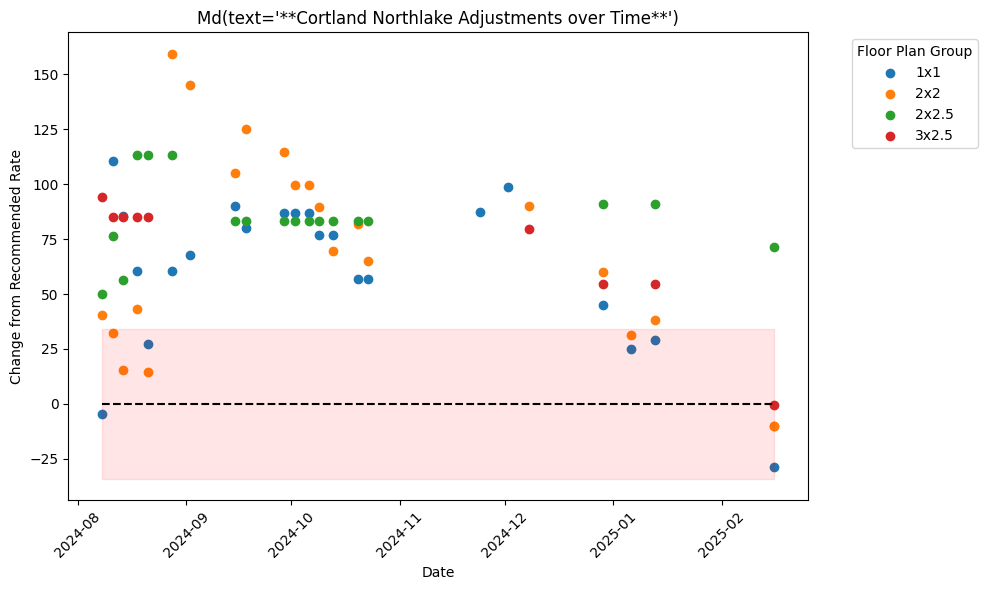

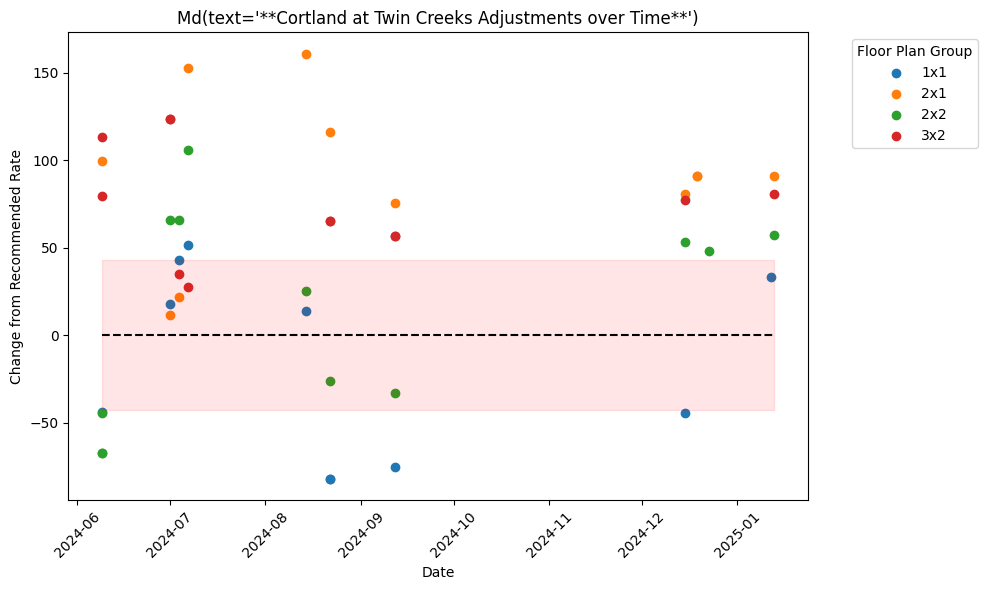

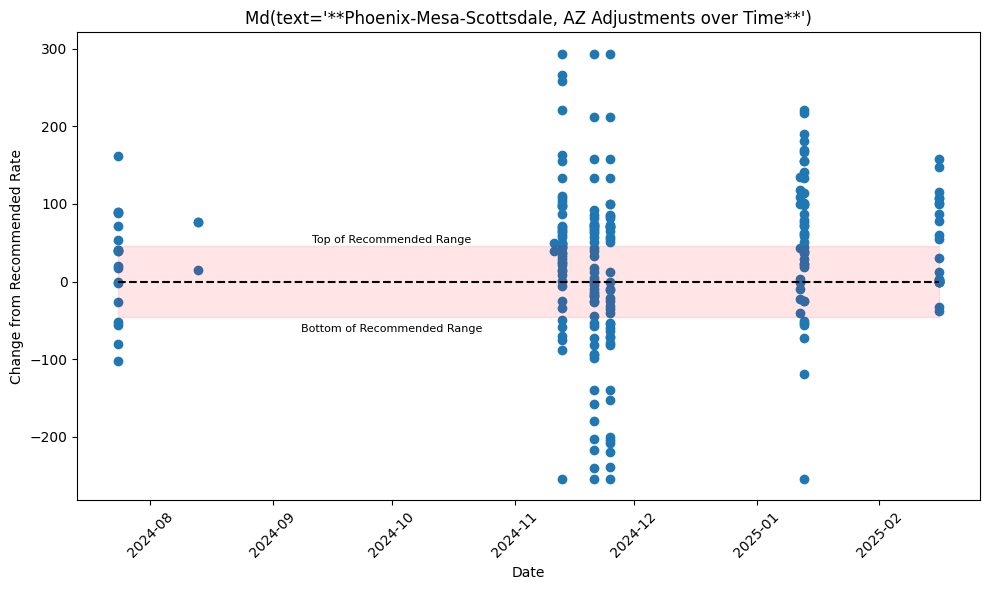

In [ ]:
def get_adj_over_time(asset_name=None, market_name=None):

    if asset_name:
        filtered = baseline_merged[baseline_merged['AssetName'] == asset_name]
    elif market_name:
        filtered = baseline_merged[baseline_merged['MarketName'] == market_name]

    filtered = filtered.sort_values('RecommendationDate').reset_index()

    avg_range = (filtered['recc_rate'] - filtered['recc_rate_lower']).mean()

    def sort_key(floor_plan):
        bedrooms, bathrooms = floor_plan.split('x')
        return (float(bedrooms), float(bathrooms)) 

    # Generate unique categories and sort them
    unique_categories = sorted(filtered['FloorPlanGroupName'].unique(), key=sort_key)
    palette = dict(zip(unique_categories, sns.color_palette("tab10", len(unique_categories))))

    # Create the scatter plot with categorical colors
    fig, ax = plt.subplots(figsize=(10,6))

    for category, color in palette.items():
        subset = filtered[filtered['FloorPlanGroupName'] == category]
        if asset_name:
            ax.scatter(subset['RecommendationDate'], subset['Diff'], color=color, label=category)
        elif market_name:
            ax.scatter(subset['RecommendationDate'], subset['Diff'], color='#1f77b4')

    # Add legend
    if asset_name:
        ax.legend(title="Floor Plan Group", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.xlabel("Date")
    plt.ylabel("Change from Recommended Rate")

    if asset_name:
        plt.title(f"{asset_name} Adjustments over Time")
    elif market_name:
        plt.title(f"{market_name} Adjustments over Time")
    
    plt.fill_between(filtered['RecommendationDate'], -avg_range, avg_range, color='red', alpha=0.1)
    plt.hlines(0, min(filtered['RecommendationDate']), max(filtered['RecommendationDate']), linestyles="dashed", colors="black")
    plt.xticks(rotation=45)
    if market_name == "Phoenix-Mesa-Scottsdale, AZ":
        plt.text(x=pd.to_datetime('2024-10-01'), y=avg_range + 5, s="Top of Recommended Range", size=8, ha='center')
        plt.text(x=pd.to_datetime('2024-10-01'), y=-avg_range - 20, s="Bottom of Recommended Range", size=8, ha='center')
    plt.style.use('seaborn-v0_8-muted')
    plt.tight_layout()
    if asset_name:
        plt.savefig(f'figures/adj_over_time/{asset_name}', )
    elif market_name:
        plt.savefig(f'figures/adj_over_time/{market_name}')
    
    plt.show()
    

get_adj_over_time(asset_name="Cortland Northlake")
get_adj_over_time(asset_name="Cortland at Twin Creeks")
get_adj_over_time(market_name="Phoenix-Mesa-Scottsdale, AZ")
# get_adj_over_time(market_name="West Palm Beach-Boca Raton-Delray Beach, FL")
# get_adj_over_time(market_name="Denver-Aurora-Lakewood, CO")
# get_adj_over_time(market_name="Colorado Springs, CO")